In [17]:
import numpy as np
import matplotlib.pyplot as plt

def short_term_plasticity_simulation(rate_hz, t_burst_start=None, t_burst_end=None, duration_ms=1000):

    # parameters
    # Depressing synapse
    tau_p_dep = 300.0  # recovery time
    p0_dep = 1.0       # resting release probability

    # Facilitating Synapse
    tau_p_fac = 100.0  
    p0_fac = 0.0       

    dt = 1.0 
    time_steps = np.arange(0, duration_ms, dt)
    rate_ms = rate_hz / 1000.0

    P_dep = p0_dep  
    P_fac = p0_fac

    presynaptic_spikes = []
    dep_releases = []
    fac_releases = []
    P_dep_trace = []
    P_fac_trace = []

    for t in time_steps:
        current_rate_ms = rate_ms
        if t_burst_start is not None and not (t_burst_start <= t < t_burst_end):
            current_rate_ms = 0.0

        P_dep += ((p0_dep - P_dep) / tau_p_dep) * dt
        P_fac += ((p0_fac - P_fac) / tau_p_fac) * dt
        
        probability = current_rate_ms * dt
        if np.random.rand() < probability:
            presynaptic_spikes.append(t)
            
            P_fac += (0.1) * (1 - P_fac)

            if np.random.rand() < P_dep:
                dep_releases.append(t)
                P_dep = 0.0 

            if np.random.rand() < P_fac:
                fac_releases.append(t)

        P_dep_trace.append(P_dep)
        P_fac_trace.append(P_fac)
        
    return time_steps, presynaptic_spikes, dep_releases, fac_releases, P_dep_trace, P_fac_trace
    


In [ ]:
def transmission_rate(rate_hz, run_duration_s=10,):
    
    duration_ms = run_duration_s * 1000
    
    _, _, dep_releases, fac_releases, _, _ = short_term_plasticity_simulation(rate_hz, duration_ms=duration_ms)
    
    dep_rate = len(dep_releases) / run_duration_s
    fac_rate = len(fac_releases) / run_duration_s
    
    return dep_rate, fac_rate

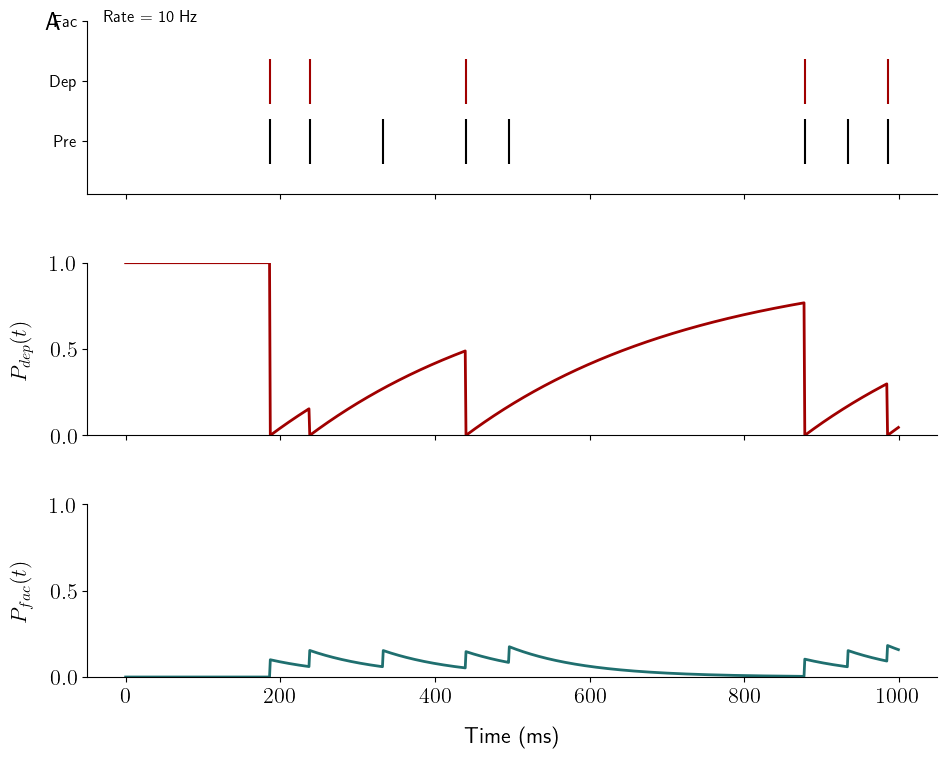

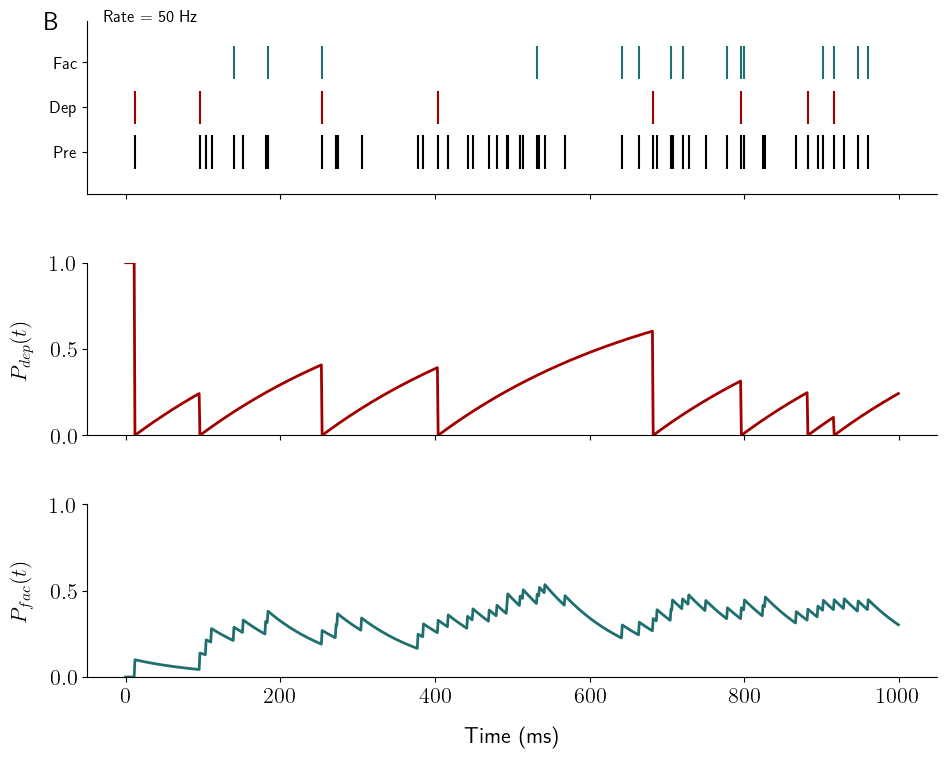

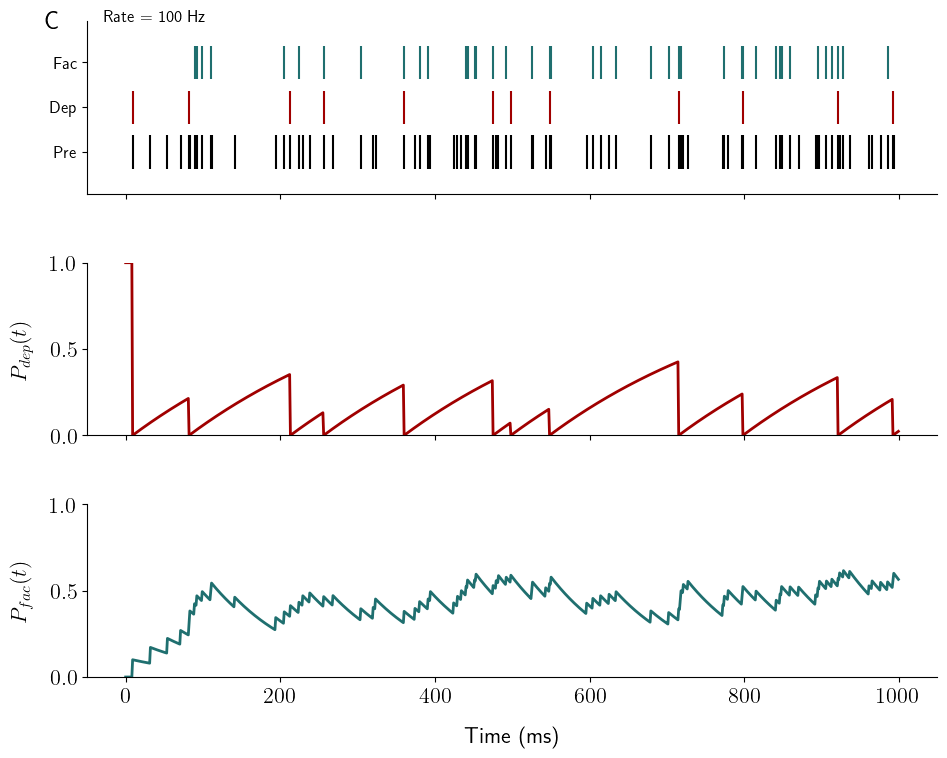

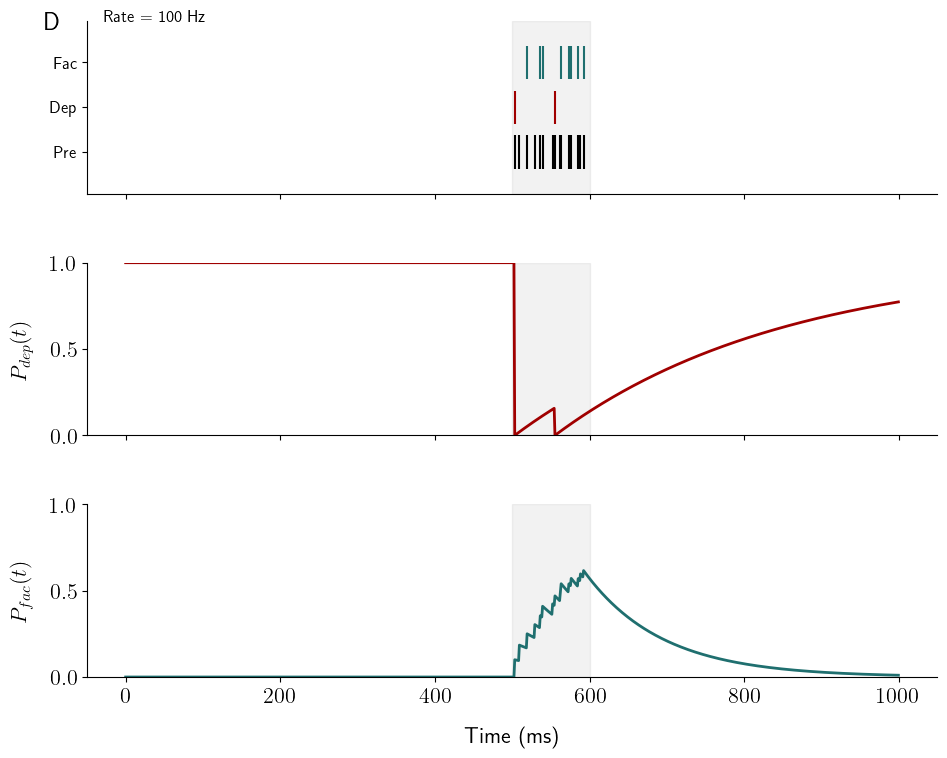

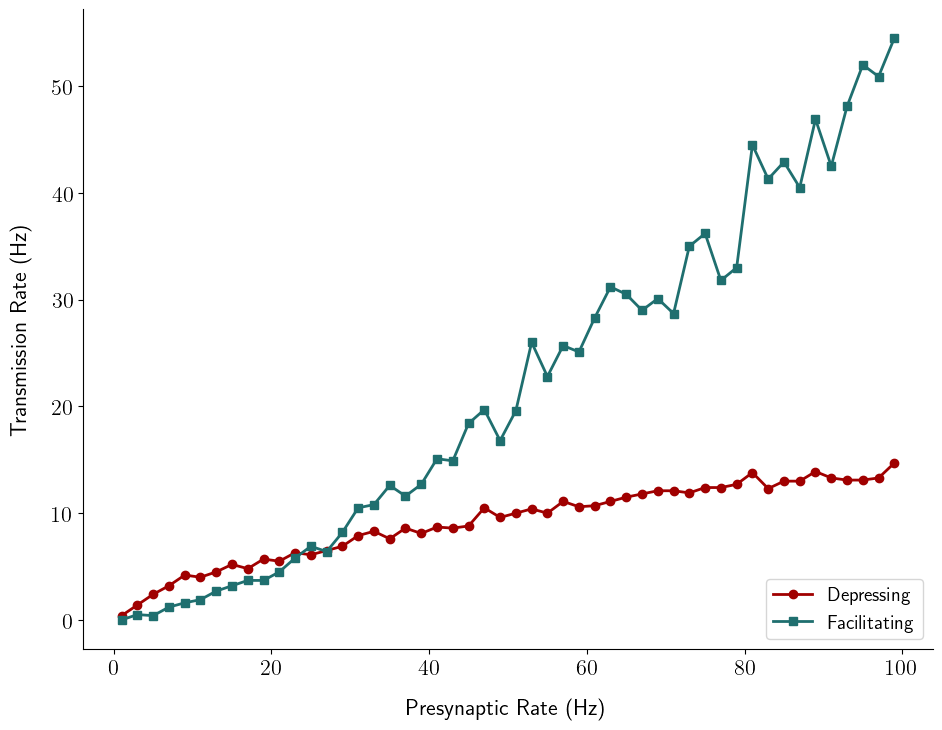

In [76]:
if __name__ == '__main__':
    plt.rcParams.update({
        'font.size': 16,
        'text.usetex': True,
        'figure.figsize': (10, 8)
    })

    def remove_spines(ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    rates_bursts = [(10, None), (50, None), (100, None), (100, (500, 600))]
    panel_labels = ['A', 'B', 'C', 'D']
    for (rate, burst), label in zip(rates_bursts, panel_labels):
        time, spikes, dep, fac, P_dep, P_fac = short_term_plasticity_simulation(
            rate, *(burst or (None, None))
        )
        fig, axes = plt.subplots(3, 1, sharex=True)

        axes[0].text(-0.05, 1.05, label, transform=axes[0].transAxes,
                    fontsize=18, fontweight='bold', va='top')
        axes[0].text(0.02, 1, f"Rate = {rate} Hz",
                    transform=axes[0].transAxes, fontsize=12, fontweight='bold' )

        axes[0].eventplot(spikes, colors='k', lineoffsets=0, linelengths=0.6)
        axes[0].eventplot(dep,    colors='#a00000', lineoffsets=0.8, linelengths=0.6)
        axes[0].eventplot(fac,    colors='#1f6f6f',      lineoffsets=1.6, linelengths=0.6)
        axes[0].set_yticks([0, 0.8, 1.6])
        axes[0].set_yticklabels(['Pre','Dep','Fac'], fontsize=12)
        if burst:
            axes[0].axvspan(burst[0], burst[1], color='gray', alpha=0.1)
        remove_spines(axes[0])


        axes[1].plot(time, P_dep, color='#a00000', linewidth=2)
        axes[1].set_ylabel(r'$P_{dep}(t)$', fontsize=16, labelpad=12)
        axes[1].set_ylim(0, 1)
        if burst:
            axes[1].axvspan(burst[0], burst[1], color='gray', alpha=0.1)
        remove_spines(axes[1])

        # P_fac
        axes[2].plot(time, P_fac, color='#1f6f6f', linewidth=2)
        axes[2].set_ylabel(r'$P_{fac}(t)$', fontsize=16, labelpad=12)
        axes[2].set_xlabel('Time (ms)', fontsize=16, labelpad=14)
        axes[2].set_ylim(0, 1)
        if burst:
            axes[2].axvspan(burst[0], burst[1], color='gray', alpha=0.1)
        remove_spines(axes[2])

        fig.subplots_adjust(top=0.92, hspace=0.4,
                            left=0.1, right=0.95, bottom=0.1)
        plt.savefig(f'STP_{rate}Hz' + ('_burst' if burst else '') + '.png', dpi=300)
        plt.show()

    # Transmission rate vs. frequency
    rates = np.arange(1, 101, 2)
    dep_rates, fac_rates = [], []
    for r in rates:
        dr, fr = transmission_rate(r)
        dep_rates.append(dr)
        fac_rates.append(fr)
    fig, ax = plt.subplots()
    ax.plot(rates, dep_rates, color='#a00000', marker='o', linestyle='-', linewidth=2,
            label='Depressing')
    ax.plot(rates, fac_rates, color='#1f6f6f',      marker='s', linestyle='-', linewidth=2,
            label='Facilitating')
    ax.set_xlabel('Presynaptic Rate (Hz)', fontsize=16, labelpad=14)
    ax.set_ylabel('Transmission Rate (Hz)', fontsize=16, labelpad=14)
    ax.legend(loc='lower right', fontsize=14)
    remove_spines(ax)
    fig.subplots_adjust(top=0.9, left=0.1, right=0.95, bottom=0.1)
    plt.savefig('rate_vs_frequency.png', dpi=300)
    plt.show()
